# Import Useful Libraries

In [1]:
import os
import random
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Used Paths

In [2]:
TestImagesPath = "test_images/"
VehiclePath = "vehicles/*/*.png"
NonVehiclePath = "non-vehicles/*/*.png"

# Help Functions

## 1. Read Images

In [3]:
def read_image(ImagePath):
    # Read images using cv2.imread.
    image = cv2.imread(ImagePath)
    
    # Convert image to RGB as cv2 reads the image in BGR. 
    image_conv = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image_conv

## 2. Extract Vehicle and Non-Vehicle Images

In [4]:
# Read training data and save them in a buffer to use them in training SVM model and Visulaization.

vehicle_images = glob.glob(VehiclePath)
non_vehicle_images = glob.glob(NonVehiclePath)

Vehicles = []
NonVehicles = []

for vehicle_image in vehicle_images:
    Vehicles.append(vehicle_image)
    
for non_vehicle_image in non_vehicle_images:
    NonVehicles.append(non_vehicle_image)

# print Data about training Data.    
print("Number of Vehicles images are" ,len(Vehicles), "Vehicles")
print("Vehicles size is ",read_image(random.choice(Vehicles)).shape)
print("Number of Non Vehicles images are" ,len(NonVehicles), "Non Vehicles")
print("Non Vehicles size is ",read_image(random.choice(NonVehicles)).shape)

Number of Vehicles images are 8792 Vehicles
Vehicles size is  (64, 64, 3)
Number of Non Vehicles images are 8968 Non Vehicles
Non Vehicles size is  (64, 64, 3)


### 2.1 Visualize random Vehicle and Non-Vehicle Images

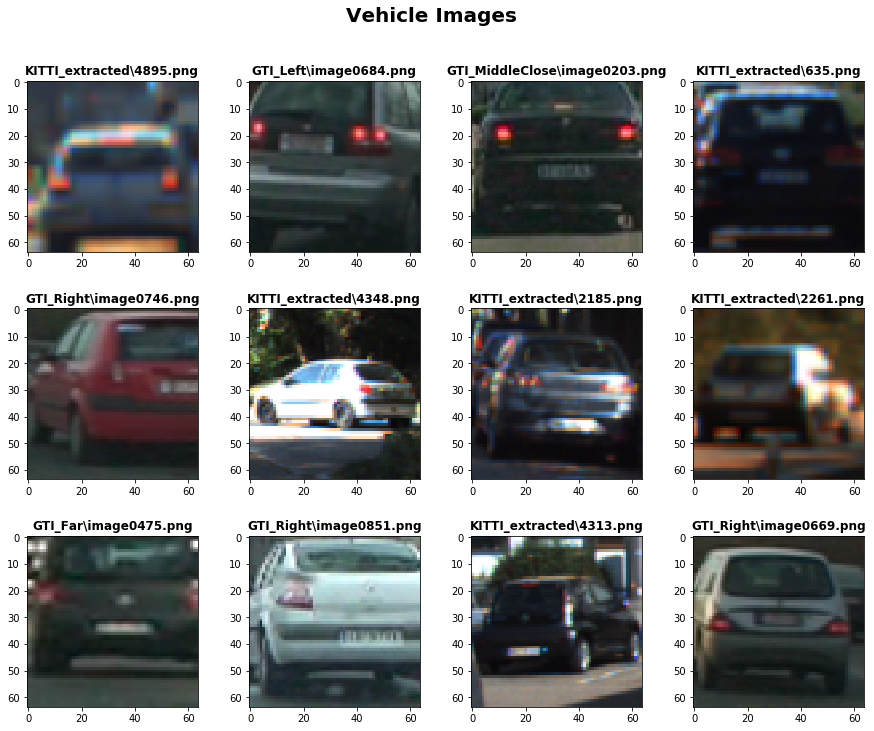

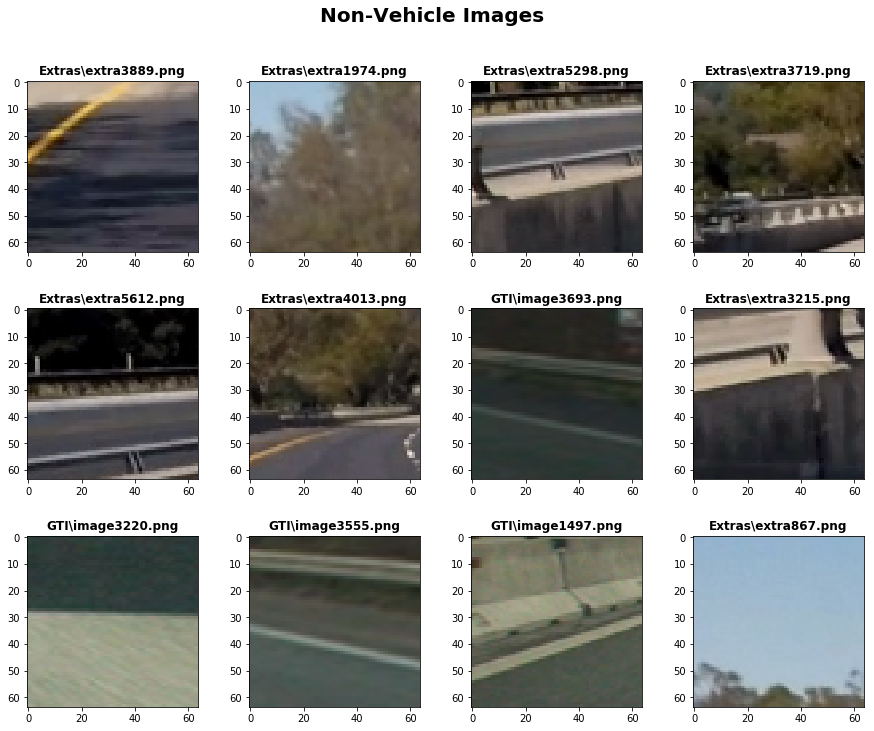

In [5]:
# Visualize training data to make sure that reading the data in correct color scheme.

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(top=1)
fig.suptitle('Vehicle Images',x = 0.5, y=1.1, fontsize=20, fontweight='bold')
fig.subplots_adjust(hspace = .3, wspace=.3)

fig2 = plt.figure(figsize=(15,10))
fig2.subplots_adjust(top=1)
fig2.suptitle('Non-Vehicle Images',x = 0.5, y=1.1, fontsize=20, fontweight='bold')
fig2.subplots_adjust(hspace = .3, wspace=.3)

# Save random Vehicle and Non-Vehicle Images in separate buffers
# ,So we can use these images in visualization in different part of the code
plot_image_veh = []
plot_image_non_veh = []

for index in range (0,12):
    
    image_veh = random.choice(Vehicles)
    plot_image_veh.append(read_image(image_veh))
    
    image_non_veh = random.choice(NonVehicles)
    plot_image_non_veh.append(read_image(image_non_veh))
    
    fig1 = fig.add_subplot( 3, 4, index + 1)
    fig1.set_title(image_veh.split("vehicles\\")[1],fontsize=12,fontweight='bold')
    fig1.imshow(plot_image_veh[index])
    
    fig3 = fig2.add_subplot( 3, 4, index + 1)
    fig3.set_title(image_non_veh.split("non-vehicles\\")[1],fontsize=12,fontweight='bold')
    fig3.imshow(plot_image_non_veh[index])
    
plt.show()

# Feature Extraction

## 1. Histograms of Color

In [6]:
# Define a function to compute color histogram features  
def color_histogram(img, nbins, bins_range):
    # Compute the histogram of the channels separately
    hist_of_chan0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist_of_chan1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist_of_chan2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist_of_chan0[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    histo_features = np.concatenate((hist_of_chan0[0], hist_of_chan1[0], hist_of_chan2[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_of_chan0, hist_of_chan1, hist_of_chan2, bin_centers, histo_features

### 1.1 Visualize Color Histograms on test Images

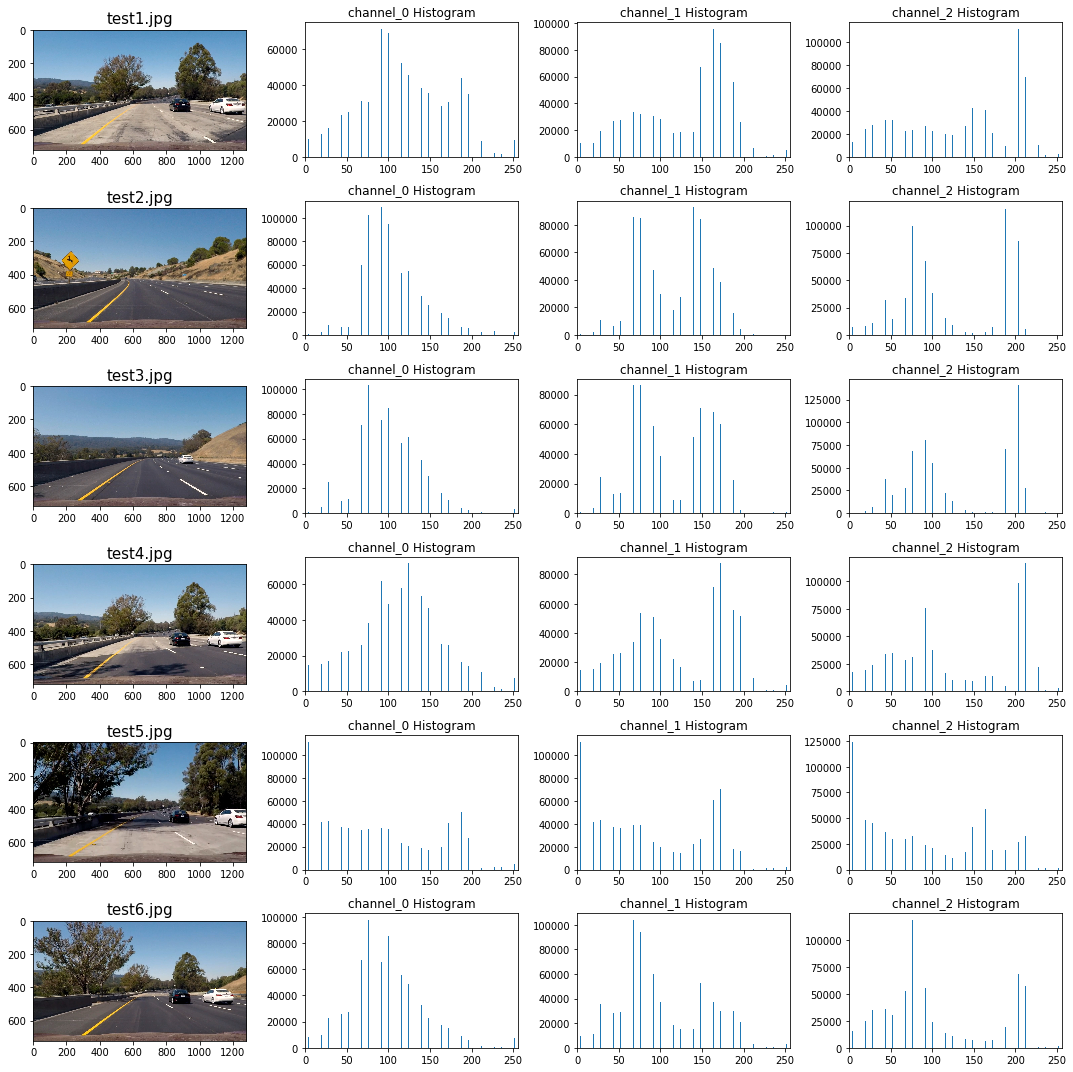

In [7]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

nbins = 32
bins_range = (0,256)

# Visualize
fig, axs = plt.subplots(6, 4, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    test_ch0, test_ch1, test_ch2, test_centers, test_histo_features  = color_histogram(test_image, 
                                                                                       nbins, 
                                                                                       bins_range)                                                                                 
    
    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].bar(test_centers, test_ch0[0])
    axs[index,1].set_xlim(0,256)
    axs[index,1].set_title('channel_0 Histogram')
    
    axs[index,2].bar(test_centers, test_ch1[0])
    axs[index,2].set_xlim(0,256)
    axs[index,2].set_title('channel_1 Histogram')
    
    axs[index,3].bar(test_centers, test_ch2[0])
    axs[index,3].set_xlim(0,256)
    axs[index,3].set_title('channel_2 Histogram')

fig.tight_layout()
plt.show()

### 1.2 Visualize Color Histograms on Vehicle images.

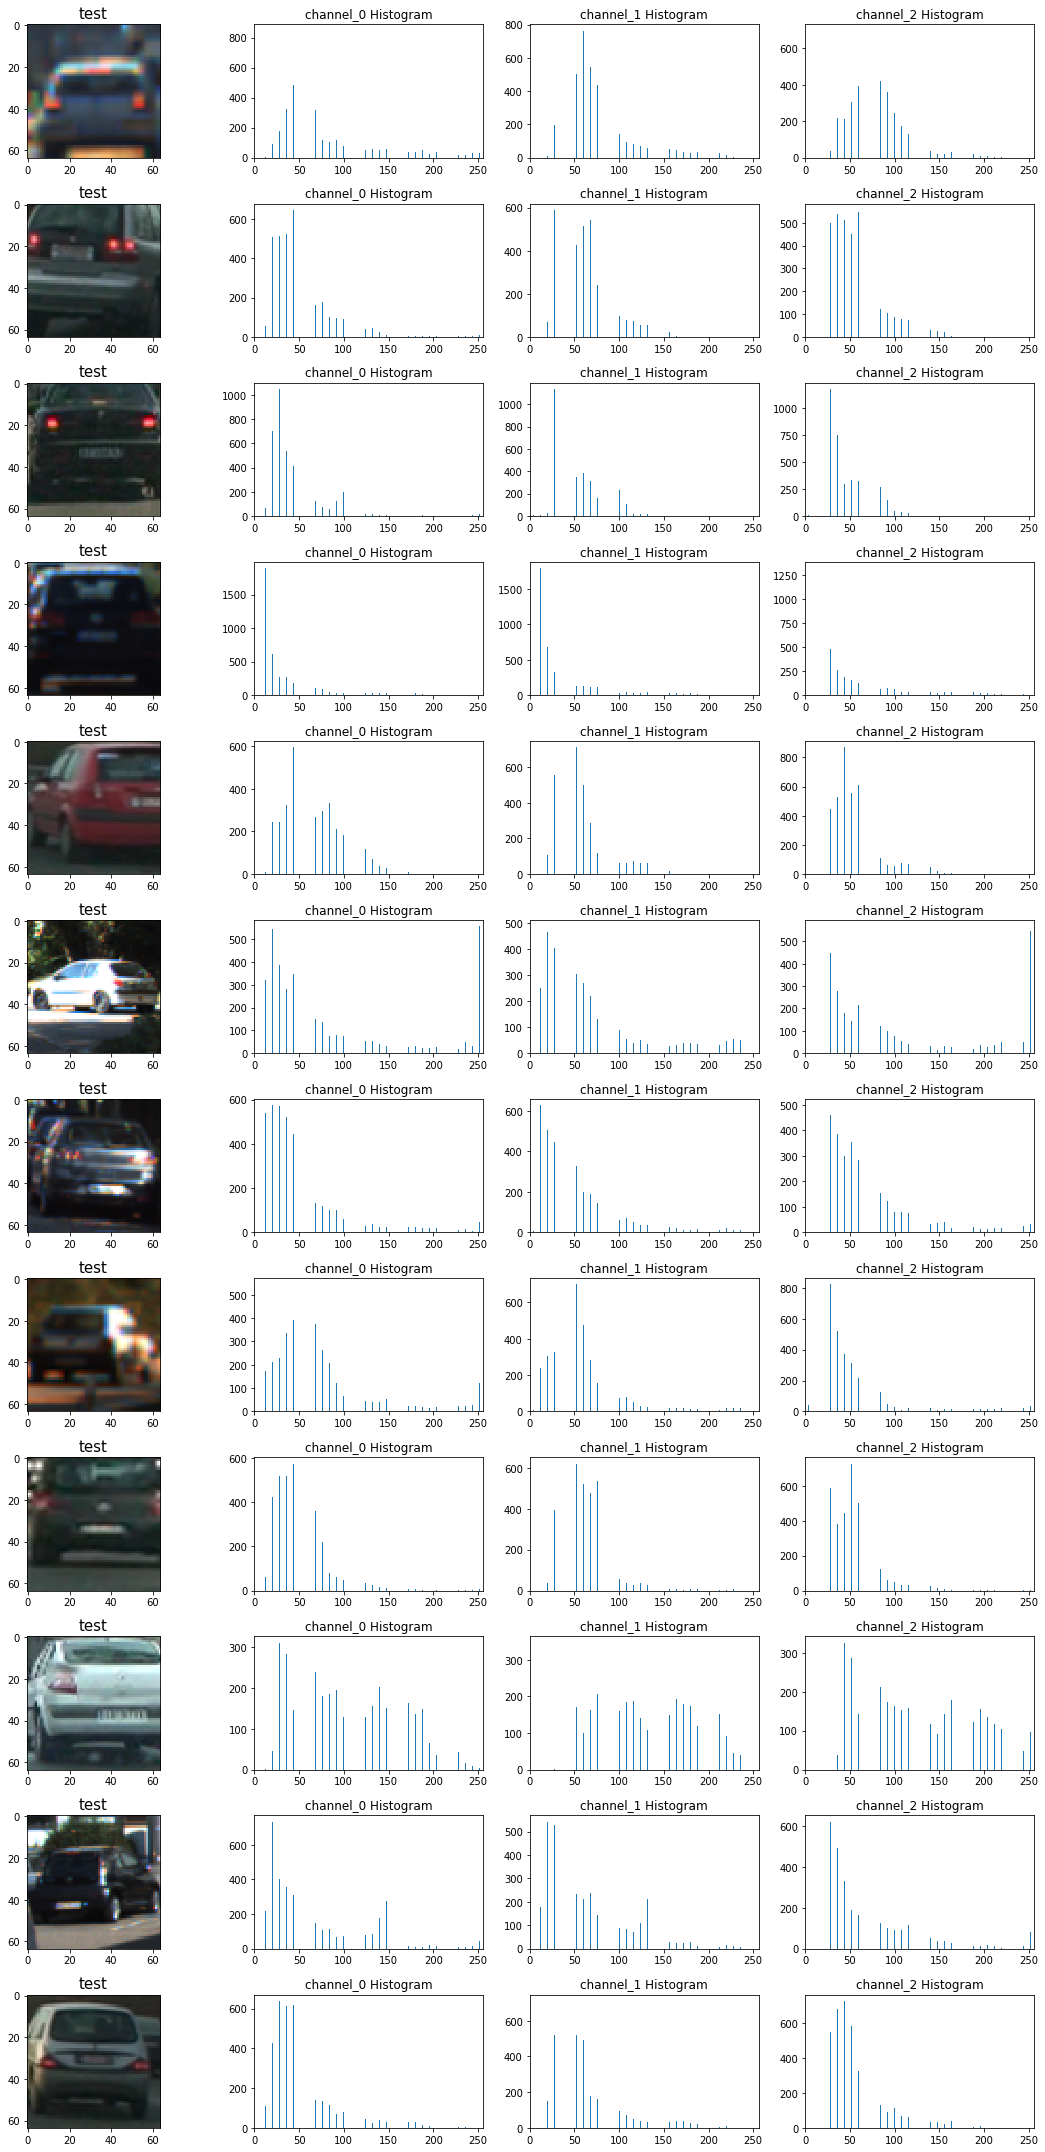

In [8]:
# Testing Vehicle images.

nbins = 32
bins_range = (0,256)

# Visualize
fig, axs = plt.subplots(12, 4, figsize=(15,30))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index in range (0,12):
    
    test_ch0, test_ch1, test_ch2, test_centers, test_histo_features  = color_histogram(plot_image_veh[index], 
                                                                                       nbins, 
                                                                                       bins_range)                                                                                 

    axs[index,0].imshow(plot_image_veh[index])
    axs[index,0].set_title("test", fontsize=15)
    
    axs[index,1].bar(test_centers, test_ch0[0])
    axs[index,1].set_xlim(0,256)
    axs[index,1].set_title('channel_0 Histogram')
    
    axs[index,2].bar(test_centers, test_ch1[0])
    axs[index,2].set_xlim(0,256)
    axs[index,2].set_title('channel_1 Histogram')
    
    axs[index,3].bar(test_centers, test_ch2[0])
    axs[index,3].set_xlim(0,256)
    axs[index,3].set_title('channel_2 Histogram')

fig.tight_layout()
plt.show()

## 2. Spatial Binning of Color

In [9]:
def bin_spatial(img, color_space, size):
    
    # Convert image to the requested color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
        
    # Flatten features after resize feature image
    features = cv2.resize(feature_image, size).ravel() 
    
    # Return the feature vector
    return features, feature_image

### 2.1 Visualize Spatial Binning of Color on test Images

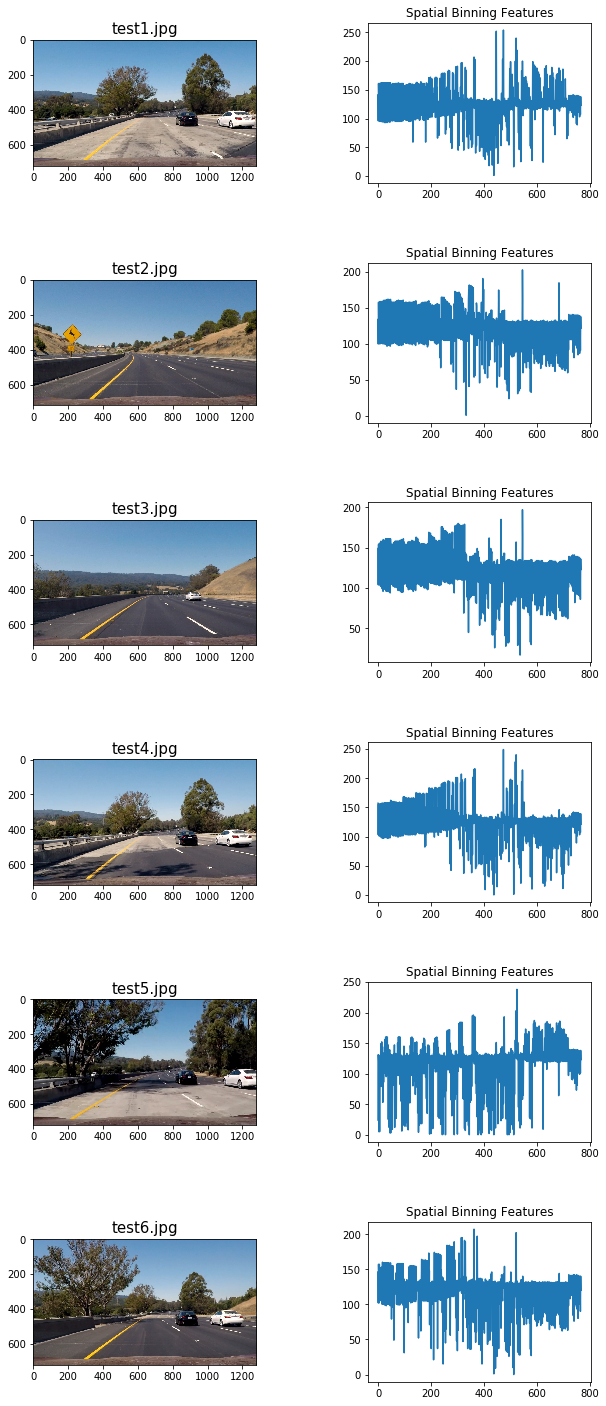

In [10]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

color_space = 'YUV'
size = (16,16)

# Visualize
fig, axs = plt.subplots(6, 2, figsize=(10,25))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    spatial_features, spatial_image  = bin_spatial(test_image, color_space, size)

    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].plot(spatial_features)
    axs[index,1].set_title('Spatial Binning Features')

plt.show()

### 2.2 Visualize Spatial Binning of Color on Vehicle images.

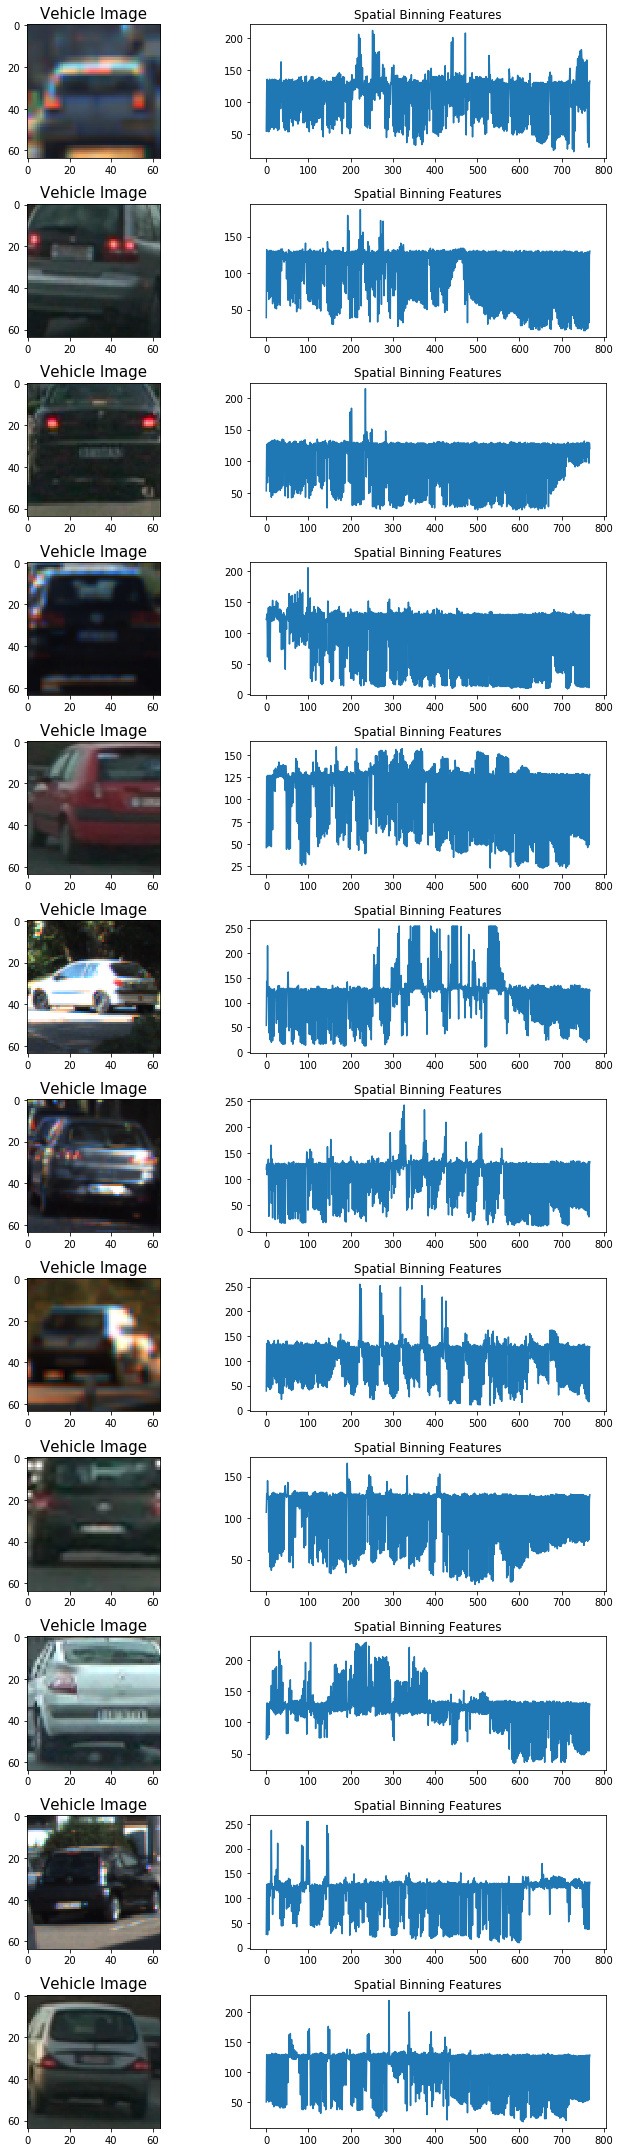

In [11]:
# Testing Vehicle images.

color_space = 'YCrCb'
size = (16,16)

# Visualize
fig, axs = plt.subplots(12, 2, figsize=(10,30))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index in range (0,12):                                                                                

    spatial_features, spatial_image  = bin_spatial(plot_image_veh[index], color_space, size)

    axs[index,0].imshow(plot_image_veh[index])
    axs[index,0].set_title("Vehicle Image", fontsize=15)
    
    axs[index,1].plot(spatial_features)
    axs[index,1].set_title('Spatial Binning Features')

fig.tight_layout()
plt.show()

## 3. Histogram of Oriented Gradient (HOG)

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec, trans_sqrt):
    
    # plot the output image of hog and return the hog features if visualization flag equals true.
    if vis == True:
        features, hog_image = hog(img, 
                                  orientations = orient,
                                  pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block),
                                  transform_sqrt = trans_sqrt, 
                                  visualise = vis,
                                  feature_vector = feature_vec)
        
        return features, hog_image
    
    # return the hog features only if visualization flag equals false.
    else:      
        features = hog(img, 
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt = trans_sqrt,
                       visualise = vis, 
                       feature_vector = feature_vec)
        
        return features

### 3.1 Visualize Hog Feature on test Images

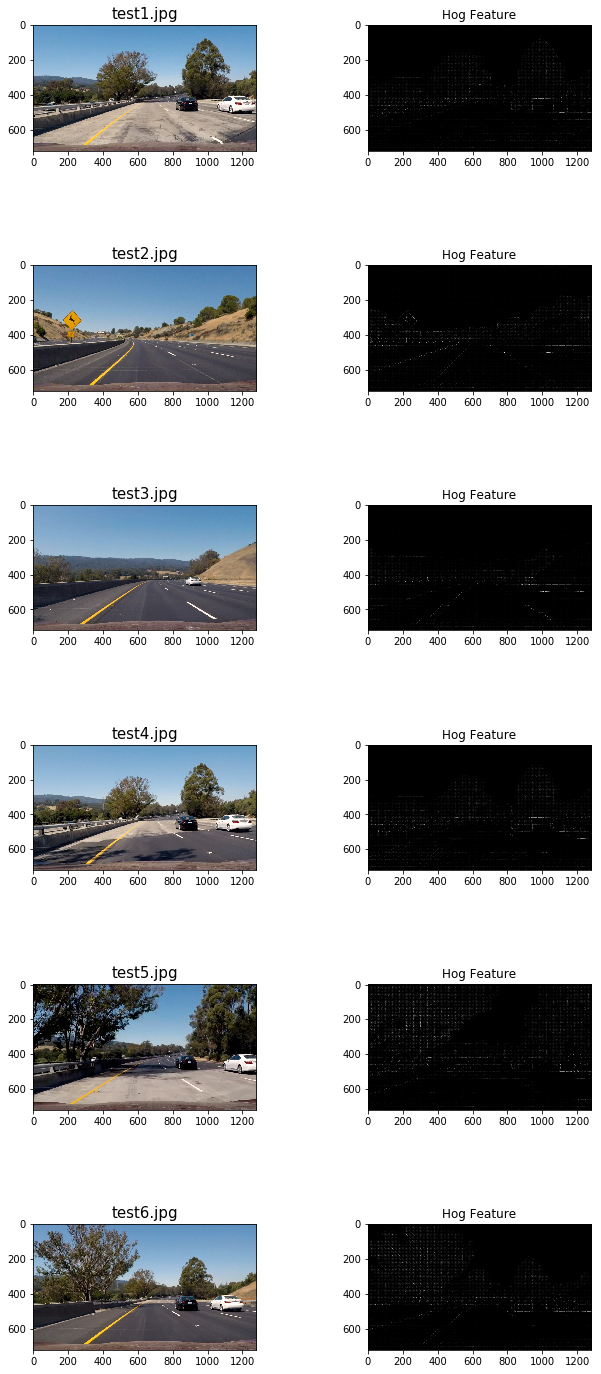

In [13]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

# Define Hog Parameters.
Orientation = 11
PixelsPerCell = 16
CellsPerBlock = 2
Transform_SQRT = True
Visualise = True
FeatureVector = True

# Visualize
fig, axs = plt.subplots(6, 2, figsize=(10,25))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    # Covert image to gray scale as hog feature requires
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    
    hog_feature, hog_image = get_hog_features(test_image_gray,
                                              Orientation,
                                              PixelsPerCell,
                                              CellsPerBlock,
                                              Visualise,
                                              FeatureVector,
                                              Transform_SQRT)

    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].imshow(hog_image,cmap = 'gray')
    axs[index,1].set_title('Hog Feature')

plt.show()

### 3.2 Visualize Hog Feature on Vehicle images.

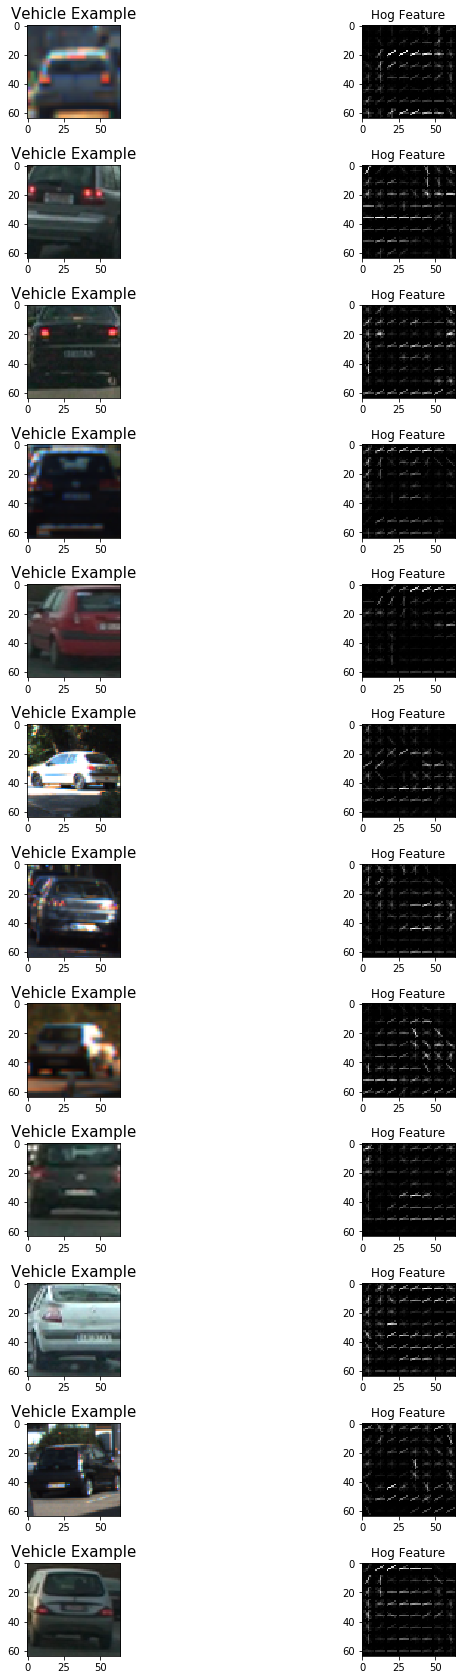

In [14]:
# Testing Vehicle images.

# Define Hog Parameters.
Orientation = 11
PixelsPerCell = 16
CellsPerBlock = 2
Transform_SQRT = True
Visualise = True
FeatureVector = True

# Visualize
fig, axs = plt.subplots(12, 2, figsize=(10,30))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index in range (0,12):  
    
    # Covert image to gray scale as hog feature requires
    veh_image_gray = cv2.cvtColor(plot_image_veh[index], cv2.COLOR_BGR2GRAY)
    
    hog_feature, hog_image = get_hog_features(veh_image_gray ,
                                                Orientation,
                                                PixelsPerCell,
                                                CellsPerBlock,
                                                Visualise,
                                                FeatureVector,
                                                Transform_SQRT)
    
    #print("image",np.array(hog_feature).shape)
    #print()

    axs[index,0].imshow(plot_image_veh[index])
    axs[index,0].set_title("Vehicle Example", fontsize=15)
    
    axs[index,1].imshow(hog_image,cmap = 'gray')
    axs[index,1].set_title('Hog Feature')

plt.show()

# Features Combination

## 1. Extract Features for a list of images.

In [15]:
def extract_features(imgs,
                        ActivateSpatial, ColorSpace, SpatialSize,
                        ActivateHisto, HistoBins, HistoBinsRange,
                        ActivateHog, Orientation, PixelsPerCell, CellsPerBlock, HogChannel,
                            Transform_SQRT, Visualise, FeatureVector):

    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for img in imgs:
        image_features = []
        # Read in each one by one
        image = read_image(img)     
        
        if ActivateSpatial == True:
            # Apply Spatial Binning Feature.
            spatial_features, color_image = bin_spatial(image, ColorSpace, SpatialSize)
            image_features.append(spatial_features)
            #print("Bin",np.array(spatial_features).shape)
            #print()
        
        if ActivateHisto == True:
            # Apply Histogram Color Feature.
            channel_0, channel_1, channel_2, bin_centers, histo_features = color_histogram(color_image, 
                                                                                           HistoBins, 
                                                                                           HistoBinsRange,)
            image_features.append(histo_features)
            #print("Col",np.array(histo_features).shape)
            #print()
        
        if ActivateHog == True:
            # Apply Hog Feature.
            if HogChannel == "ALL":
                hog_features = []
                for channel in range(color_image.shape[2]):
                    hog_features.append(get_hog_features(color_image[:,:,channel], 
                                        Orientation,
                                        PixelsPerCell,
                                        CellsPerBlock,
                                        Visualise,
                                        FeatureVector,
                                        Transform_SQRT))
                hog_features = np.ravel(hog_features)
                #print("hog",np.array(hog_features).shape)
                #print()
                
            else:
                hog_features = get_hog_features(color_image[:,:,HogChannel], 
                                                Orientation,
                                                PixelsPerCell,
                                                CellsPerBlock,
                                                Visualise,
                                                FeatureVector,
                                                Transform_SQRT)
                
            # Append the new feature vector to the features list
            image_features.append(hog_features)
            #print("image",np.array(image_features).shape)
            #print()
            
        features.append(np.concatenate(image_features))
        #print("total",np.array(features).shape)
        #print()
        #print()
        
    # Return list of feature vectors
    return features

## 2. Extract Features for a single image.

In [16]:
def extract_features_one_image(image,
                        ActivateSpatial, ColorSpace, SpatialSize,
                        ActivateHisto, HistoBins, HistoBinsRange,
                        ActivateHog, Orientation, PixelsPerCell, CellsPerBlock, HogChannel,
                            Transform_SQRT, Visualise, FeatureVector):

    # Create a list to append feature vectors to
    features = []

    image_features = []
    # Read in each one by one
    #image = read_image(img)     

    if ActivateSpatial == True:
        # Apply Spatial Binning Feature.
        spatial_features, color_image = bin_spatial(image, ColorSpace, SpatialSize)
        image_features.append(spatial_features)
        #print(np.array(spatial_features).shape)
    
    if ActivateHisto == True:
        # Apply Histogram Color Feature.
        channel_0, channel_1, channel_2, bin_centers, histo_features = color_histogram(color_image, 
                                                                                       HistoBins, 
                                                                                       HistoBinsRange,)
        image_features.append(histo_features)
        #print(np.array(histo_features).shape)
        
    if ActivateHog == True:
        # Apply Hog Feature.
        if HogChannel == "ALL":
            hog_features = []
            for channel in range(color_image.shape[2]):
                hog_features.append(get_hog_features(color_image[:,:,channel], 
                                                        Orientation,
                                                        PixelsPerCell,
                                                        CellsPerBlock,
                                                        Visualise,
                                                        FeatureVector,
                                                        Transform_SQRT))
            hog_features = np.ravel(hog_features)
            #print(np.array(hog_features).shape)

        else:
            hog_features = get_hog_features(color_image[:,:,HogChannel], 
                                                        Orientation,
                                                        PixelsPerCell,
                                                        CellsPerBlock,
                                                        Visualise,
                                                        FeatureVector,
                                                        Transform_SQRT)

        # Append the new feature vector to the features list
        image_features.append(hog_features)
        #print(np.array(image_features).shape)
        
    features.append(np.concatenate(image_features))
        
    # Return list of feature vectors
    return features

# Build a Classifier

## 1. Data Preparation

In [17]:

#Define Parameters Data for feature extraction.

# Spatial Parameters
Activate_Spatial = True
Color_Space = 'YUV'
Spatial_Size = (16,16)

# Color Histogram Parameters
Activate_Histo = True
Histo_Bins = 32
Histo_Bins_Range = (0,256)

# Hog Parameters
Activate_Hog = True
Orientation = 11
Pixels_Per_Cell = 16
Cells_Per_Block = 2
Hog_Channel = "ALL"
Transform_SQRT = True
Visualise = False
Feature_Vector = True


car_features = extract_features(Vehicles,
                        Activate_Spatial, Color_Space, Spatial_Size,
                        Activate_Histo, Histo_Bins, Histo_Bins_Range,
                        Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                            Transform_SQRT, Visualise, Feature_Vector)


notcar_features = extract_features(NonVehicles,
                        Activate_Spatial, Color_Space, Spatial_Size,
                        Activate_Histo, Histo_Bins, Histo_Bins_Range,
                        Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                            Transform_SQRT, Visualise, Feature_Vector)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',Orientation,'orientations',Pixels_Per_Cell,
    'pixels per cell and', Cells_Per_Block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052


## 2. Train a Classifier

In [18]:
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

2.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


# Sliding Window and Search windows Techniques.

## 1. Draw Boxes

In [19]:
def draw_boxes(img, bboxes, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## 2. Sliding window

In [20]:
def slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### 2.1 Visualize Slide Window technique and draw boxes.

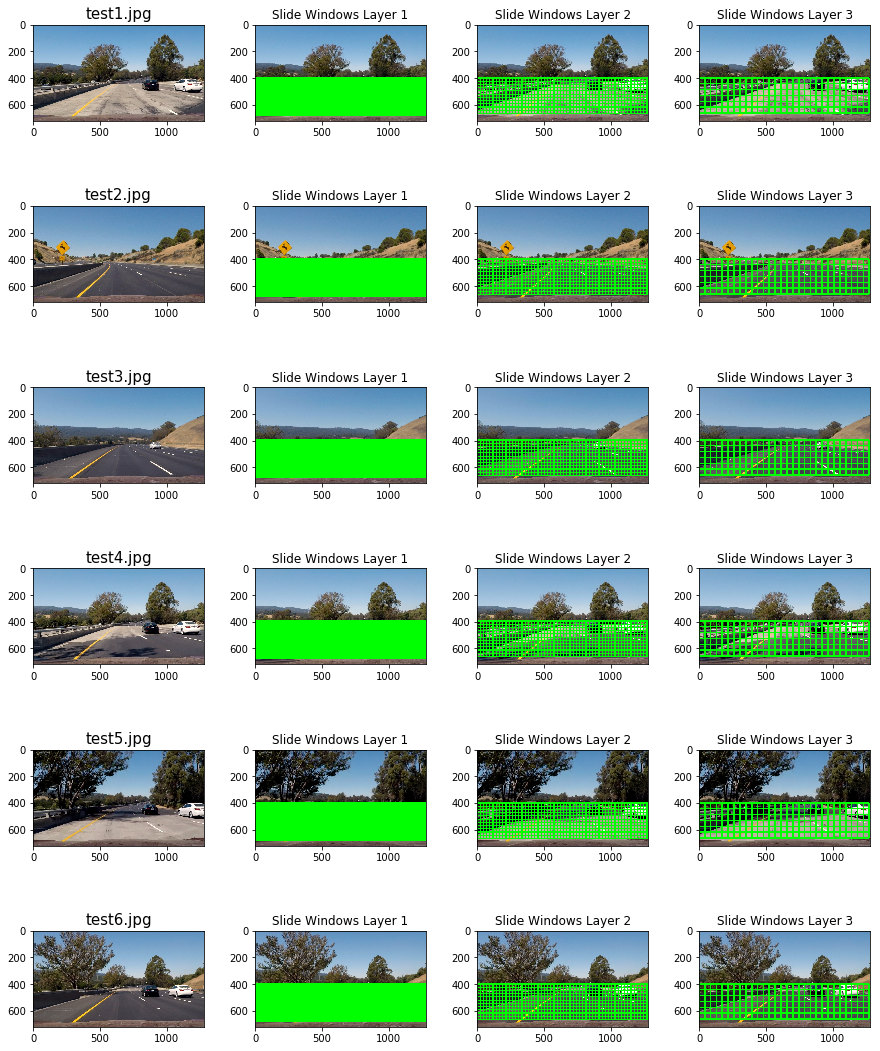

In [21]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

# Sliding windows parameters.

x_start_stop = [0,1300]
y_start_stop = [400, 680]
xy_window0 = (64, 64)
xy_window1 = (96, 96)
xy_window2 = (128, 128)
xy_overlap0 = (0.85,0.85)
xy_overlap1 = (0.75,0.75)
xy_overlap2 = (0.65,0.65)

boxes_color = (0,255,0)
boxes_thickness = 8

# Visualize
fig, axs = plt.subplots(6, 4, figsize=(15,20))
fig.subplots_adjust(hspace = 0, wspace=.3)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    Windows0 = slide_window(test_image, x_start_stop, y_start_stop, xy_window0, xy_overlap0)
    images_to_draw0 = draw_boxes(test_image, Windows0, boxes_color, boxes_thickness)

    Windows1 = slide_window(test_image, x_start_stop, y_start_stop, xy_window1, xy_overlap1)
    images_to_draw1 = draw_boxes(test_image, Windows1, boxes_color, boxes_thickness)
    
    Windows2 = slide_window(test_image, x_start_stop, y_start_stop, xy_window2, xy_overlap2)
    images_to_draw2 = draw_boxes(test_image, Windows2, boxes_color, boxes_thickness)
    
    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].imshow(images_to_draw0)
    axs[index,1].set_title('Slide Windows Layer 1')
    
    axs[index,2].imshow(images_to_draw1)
    axs[index,2].set_title('Slide Windows Layer 2')
    
    axs[index,3].imshow(images_to_draw2)
    axs[index,3].set_title('Slide Windows Layer 3')

plt.show()

## 3. Search window 

In [22]:
def search_windows(img, windows, clf, scaler, 
                    Activate_Spatial, Color_Space, Spatial_Size,
                    Activate_Histo, Histo_Bins, Histo_Bins_Range,
                    Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                    Transform_SQRT, Visualise, Feature_Vector):

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # Extract features for that window.
        features = extract_features_one_image(test_img,
                                        Activate_Spatial, Color_Space, Spatial_Size,
                                        Activate_Histo, Histo_Bins, Histo_Bins_Range,
                                        Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                                            Transform_SQRT, Visualise, Feature_Vector)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    # Return windows for positive detections
    return on_windows

### 3.1 Visualize Search Window

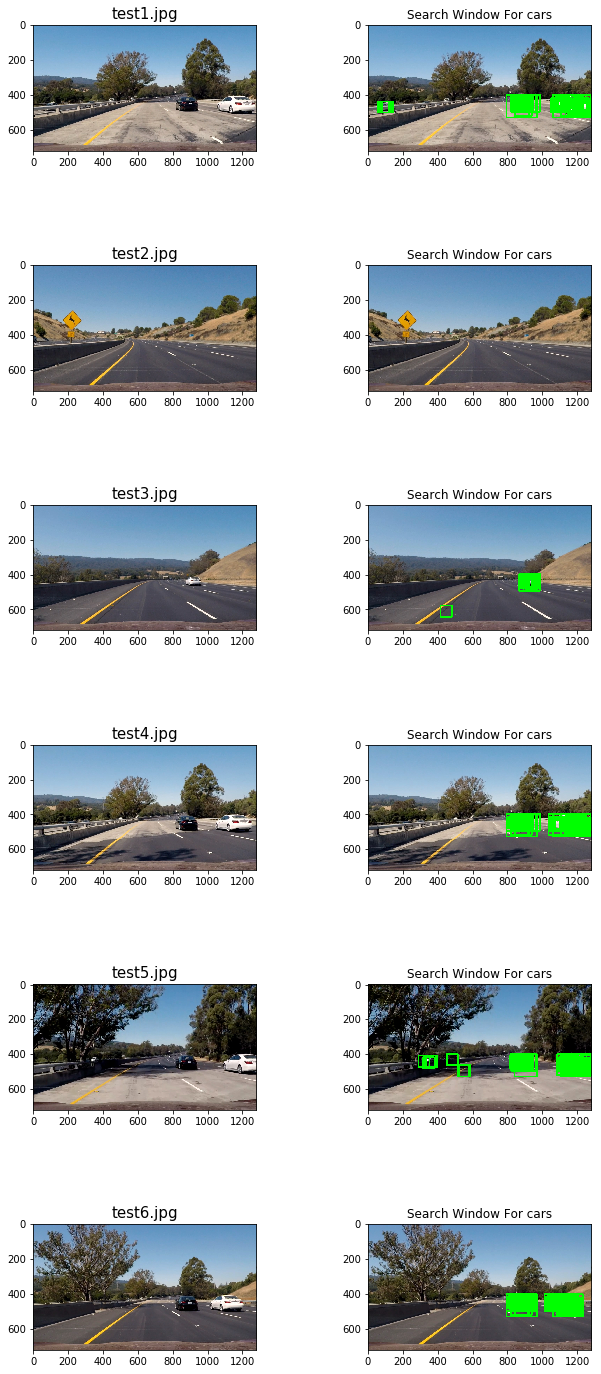

In [23]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

# Sliding windows parameters.
x_start_stop = [0,1300]
y_start_stop = [400, 680]
xy_window0 = (64, 64)
xy_window1 = (96, 96)
xy_window2 = (128, 128)
xy_overlap0 = (0.85,0.85)
xy_overlap1 = (0.75,0.75)
xy_overlap2 = (0.65,0.65)


# Search Window Parameters.
Classifier = svc
Scaler = X_scaler

# Spatial Parameters
Activate_Spatial = True
Color_Space = 'YUV'
Spatial_Size = (16,16)

# Color Histogram Parameters
Activate_Histo = True
Histo_Bins = 32
Histo_Bins_Range = (0,256)

# Hog Parameters
Activate_Hog = True
Orientation = 11
Pixels_Per_Cell = 16
Cells_Per_Block = 2
Hog_Channel = "ALL"
Transform_SQRT = True
Visualise = False
Feature_Vector = True

# Draw Boxes Parameters
Boxes_Color = (0,255,0)
Boxes_Thickness = 8

# Visualize
fig, axs = plt.subplots(6, 2, figsize=(10,25))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    draw_image = np.copy(test_image)
    
    Windows = slide_window(test_image, x_start_stop, y_start_stop, xy_window0, xy_overlap0)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window1, xy_overlap1)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window2, xy_overlap2)
    
    
    Hot_Windows = search_windows(test_image, Windows, Classifier, Scaler, 
                    Activate_Spatial, Color_Space, Spatial_Size,
                    Activate_Histo, Histo_Bins, Histo_Bins_Range,
                    Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                    Transform_SQRT, Visualise, Feature_Vector)
    
    images_to_draw = draw_boxes(draw_image, Hot_Windows, Boxes_Color, Boxes_Thickness)


    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].imshow(images_to_draw)
    axs[index,1].set_title('Search Window For cars')

plt.show()

# Multiple Detections & False Positives

## 1. Apply Heat Map

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

## 2. Apply threshold on heatmap images

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## 3. Draw Labeled Boxes

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### 3.1 Visualize Multiple Detections & False Positives

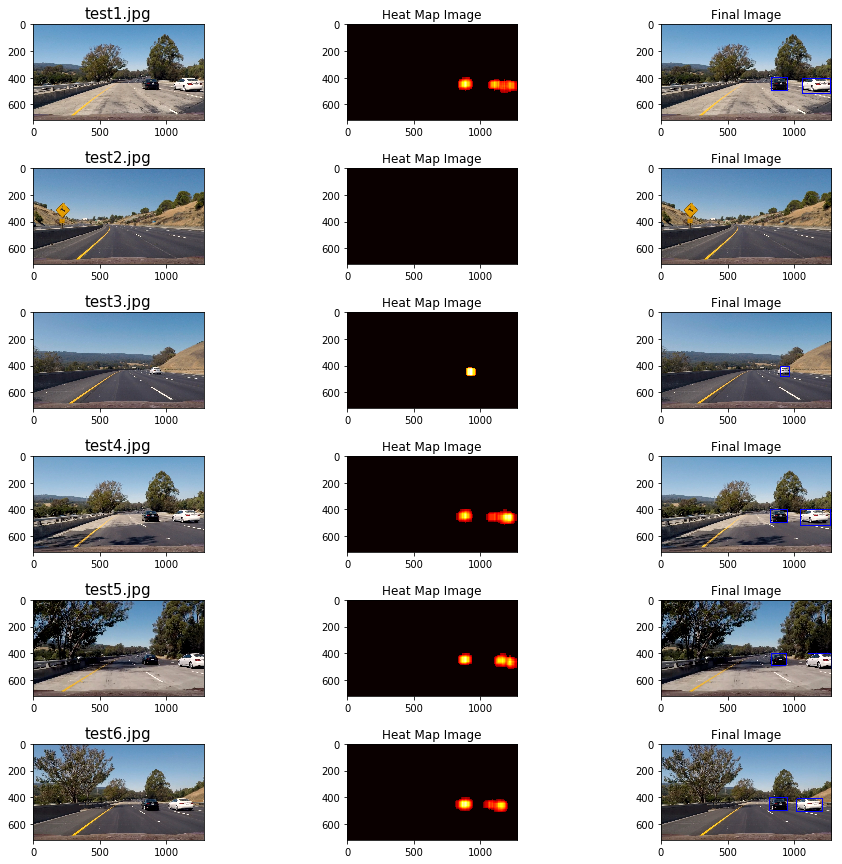

In [27]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

# Sliding windows parameters.
x_start_stop = [0,1300]
y_start_stop = [400, 680]
xy_window0 = (64, 64)
xy_window1 = (96, 96)
xy_window2 = (128, 128)
xy_overlap0 = (0.85,0.85)
xy_overlap1 = (0.75,0.75)
xy_overlap2 = (0.65,0.65)

# Search Window Parameters.
Classifier = svc
Scaler = X_scaler

# Spatial Parameters
Activate_Spatial = True
Color_Space = 'YUV'
Spatial_Size = (16,16)

# Color Histogram Parameters
Activate_Histo = True
Histo_Bins = 32
Histo_Bins_Range = (0,256)

# Hog Parameters
Activate_Hog = True
Orientation = 11
Pixels_Per_Cell = 16
Cells_Per_Block = 2
Hog_Channel = "ALL"
Transform_SQRT = True
Visualise = False
Feature_Vector = True

# Visualize
fig, axs = plt.subplots(6, 3, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    draw_image = np.copy(test_image)
    
    Windows = slide_window(test_image, x_start_stop, y_start_stop, xy_window0, xy_overlap0)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window1, xy_overlap1)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window2, xy_overlap2)
    
    
    Hot_Windows = search_windows(test_image, Windows, Classifier, Scaler, 
                    Activate_Spatial, Color_Space, Spatial_Size,
                    Activate_Histo, Histo_Bins, Histo_Bins_Range,
                    Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                    Transform_SQRT, Visualise, Feature_Vector)

    # Add heat to each box in box list
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,Hot_Windows)

    # Apply threshold to help remove false positives
    heat_threshold = apply_threshold(heat,6)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_threshold, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    heat_image = draw_labeled_bboxes(draw_image, labels)
    

    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].imshow(heatmap,cmap='hot')
    axs[index,1].set_title('Heat Map Image')
    
    axs[index,2].imshow(heat_image,cmap='hot')
    axs[index,2].set_title('Final Image')

plt.show()

# Pipeline

## 1. Pipeline Parameters

In [28]:
# Sliding windows parameters.
x_start_stop = [0,1300]
y_start_stop = [400, 680]
xy_window0 = (64, 64)
xy_window1 = (96, 96)
xy_window2 = (128, 128)
xy_overlap0 = (0.85, 0.85)
xy_overlap1 = (0.75, 0.75)
xy_overlap2 = (0.65, 0.65)

# Search Window Parameters.
Classifier = svc
Scaler = X_scaler

# Spatial Parameters
Activate_Spatial = True
Color_Space = 'YUV'
Spatial_Size = (16,16)

# Color Histogram Parameters
Activate_Histo = True
Histo_Bins = 32
Histo_Bins_Range = (0,256)

# Hog Parameters
Activate_Hog = True
Orientation = 11
Pixels_Per_Cell = 16
Cells_Per_Block = 2
Hog_Channel = "ALL"
Transform_SQRT = True
Visualise = False
Feature_Vector = True

## 2. Pipeline Implementation

In [29]:
def detect_vehicles(test_image):
    
    draw_image = np.copy(test_image)
    
    Windows = slide_window(test_image, x_start_stop, y_start_stop, xy_window0, xy_overlap0)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window1, xy_overlap1)
    Windows += slide_window(test_image, x_start_stop, y_start_stop, xy_window2, xy_overlap2)
    
    
    Hot_Windows = search_windows(test_image, Windows, Classifier, Scaler, 
                    Activate_Spatial, Color_Space, Spatial_Size,
                    Activate_Histo, Histo_Bins, Histo_Bins_Range,
                    Activate_Hog, Orientation, Pixels_Per_Cell, Cells_Per_Block, Hog_Channel,
                    Transform_SQRT, Visualise, Feature_Vector)
    
    # Add heat to each box in box list
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,Hot_Windows)

    # Apply threshold to help remove false positives
    heat_threshold = apply_threshold(heat,6)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_threshold, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    heat_image = draw_labeled_bboxes(draw_image, labels)
    
    return heat_image

### 2.1 Run Pipeline on test images 

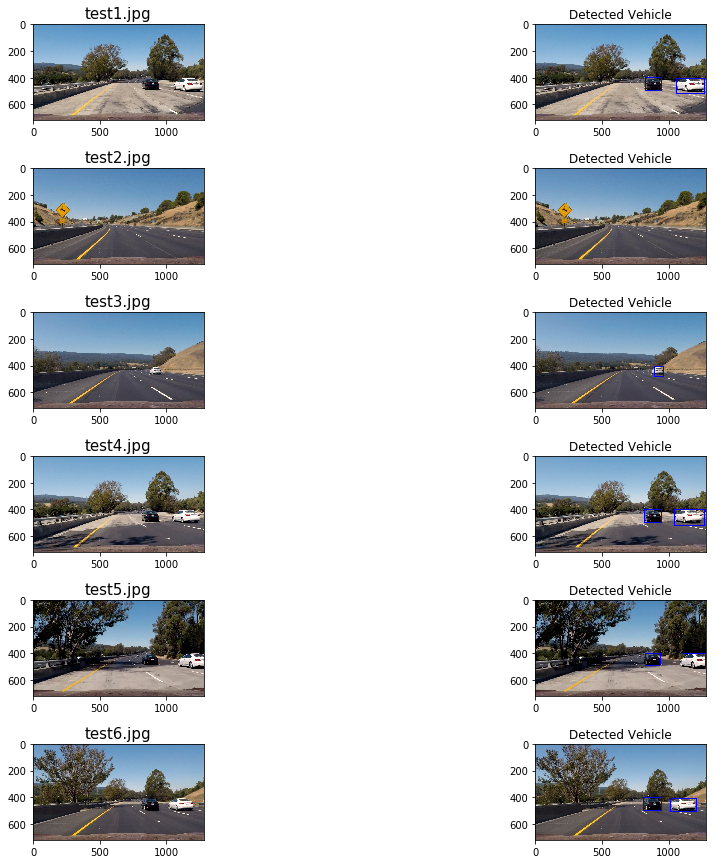

In [30]:
# Testing images in folder test_example.
test_image_path = os.listdir(TestImagesPath)

# Visualize
fig, axs = plt.subplots(6, 2, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.5)

for index,image in enumerate(test_image_path):
    
    # Read an image from test_example folder.
    test_image = read_image(TestImagesPath+image)
    
    detected_vehicle_image = detect_vehicles(test_image)
    
    axs[index,0].imshow(test_image)
    axs[index,0].set_title(image, fontsize=15)
    
    axs[index,1].imshow(detected_vehicle_image)
    axs[index,1].set_title('Detected Vehicle')
plt.show()    

### 2.2 Run Pipeline on test video

In [31]:
test_video_output = 'test_video_output.mp4'
test_video = VideoFileClip("test_video.mp4")
test_video_output_data = test_video.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time test_video_output_data.write_videofile(test_video_output, audio=False)

### 2.3 Run Pipeline on Project Video

In [ ]:
project_video_output = 'project_video_output.mp4'
project_video = VideoFileClip("project_video.mp4")
project_video_output_data = project_video.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time project_video_output_data.write_videofile(project_video_output, audio=False)